In [1]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython import display

# Load sequences

In [2]:
reaction_sequences = pickle.load(open("/home/abhor/Desktop/datasets/my_uspto/intermediate_sequences.pickle", 'rb'))

# convert list of list of sequences to list of sequences
temp = []
while reaction_sequences:
    temp.extend(reaction_sequences.pop(0))
reaction_sequences = temp

In [3]:
len(reaction_sequences)

453372

In [4]:
temp = list(map(len, reaction_sequences))

pd.value_counts(temp)

2     188216
3      80423
4      45852
5      31581
6      22576
7      18141
8      15327
9      13207
10     11380
11      9352
12      6752
13      4098
14      2377
15      1345
16       777
17       458
18       373
19       303
21       241
20       225
22       216
23       121
24        31
dtype: int64

# Analysis on sequences of L=5

In [5]:
# filter sequences of L=5
subseq = np.array(list(filter(lambda x: len(x) == 5, reaction_sequences)))

subseq.shape, f"{len(subseq) / len(reaction_sequences) * 100} % of all sequences"

((31581, 5), '6.965802916810036 % of all sequences')

# an example reaction sequence
for smile in subseq[1]:
    mol = Chem.MolFromSmiles(smile)
    Chem.Draw.MolToMPL(mol)
    pass

In [8]:
import tqdm
from rdkit.Chem import Crippen, QED, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

In [9]:
# some helper functions for the properties
def _mol(smile): 
    return Chem.MolFromSmiles(smile)
def _logp(smile): 
    return Crippen.MolLogP(_mol(smile))
def _qed(smile):
    mol = _mol(smile)
    return QED.qed(mol, QED.properties(mol))
def _sim(smile1, smile2):
    mol1 = _mol(smile1)
    mol2 = _mol(smile2)
    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [15]:
# creating dict for faster mapping of logP and QED
logp_dict = {}
qed_dict = {}

for s in tqdm.tqdm(np.unique(subseq.flatten()), total=subseq.shape[0]):
    logp_dict[s] = _logp(s)
    qed_dict[s] = _qed(s)

# sequences of logp, qed and sim
logp_sequence = np.vectorize(logp_dict.get)(subseq)
qed_sequence = np.vectorize(qed_dict.get)(subseq)

sim_sequence = []
end = subseq.shape[1]
for row in tqdm.tqdm(subseq, total=subseq.shape[0]):
    sim_sequence.append([_sim(row[i], row[i-1]) for i in range(1, end)])

sim_sequence = np.array(sim_sequence)

print(logp_sequence.shape, qed_sequence.shape, sim_sequence.shape)

53316it [01:35, 559.48it/s]                                                                          
100%|█████████████████████████████████████████████████████████| 31581/31581 [01:19<00:00, 397.87it/s]

(31581, 5) (31581, 5) (31581, 4)


# Plots

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

sns.set(rc={'figure.figsize':(16, 6)})

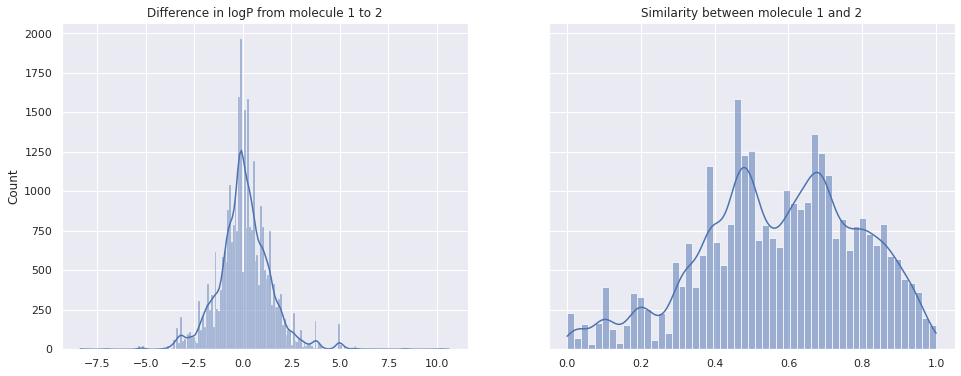

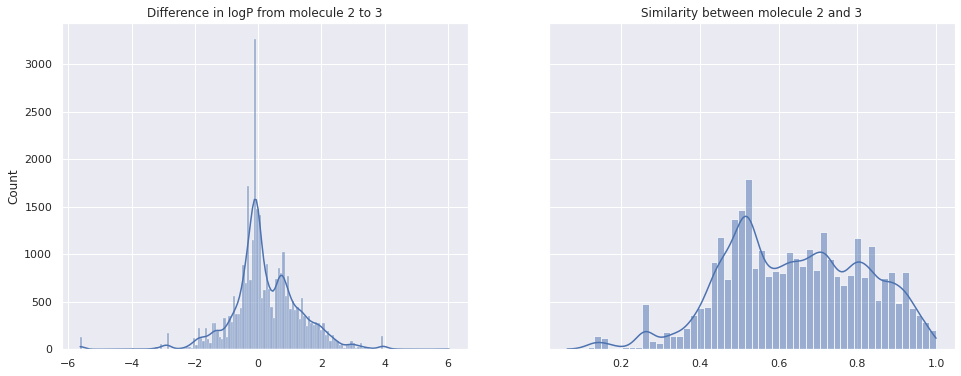

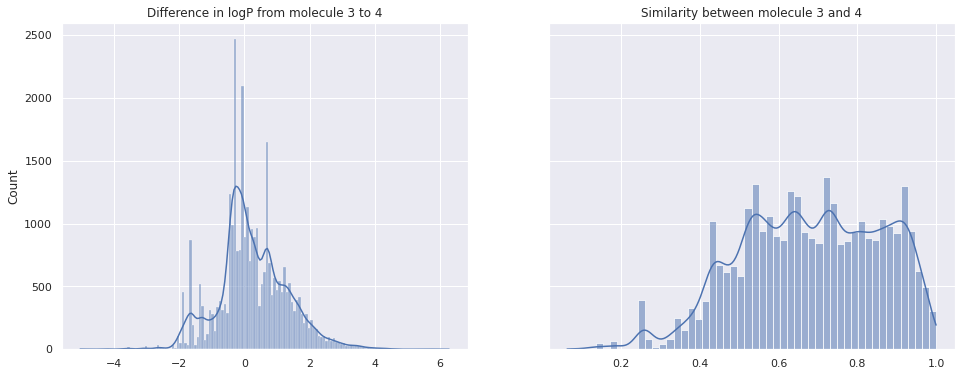

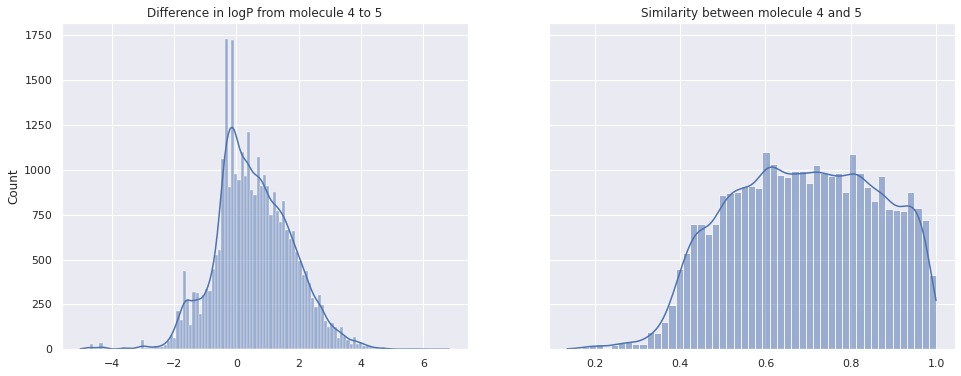

In [17]:
for i in range(1, logp_sequence.shape[1]):
    subfig, ax = plt.subplots(1, 2, sharey=True)

    fig = sns.histplot(logp_sequence[:, i] - logp_sequence[:, i-1], kde=True, ax=ax[0])
    fig.set(title=f"Difference in logP from molecule {i} to {i+1}")
    
    fig = sns.histplot(sim_sequence[:, i-1], kde=True, ax=ax[1])
    fig.set(title=f"Similarity between molecule {i} and {i+1}")
    plt.show()

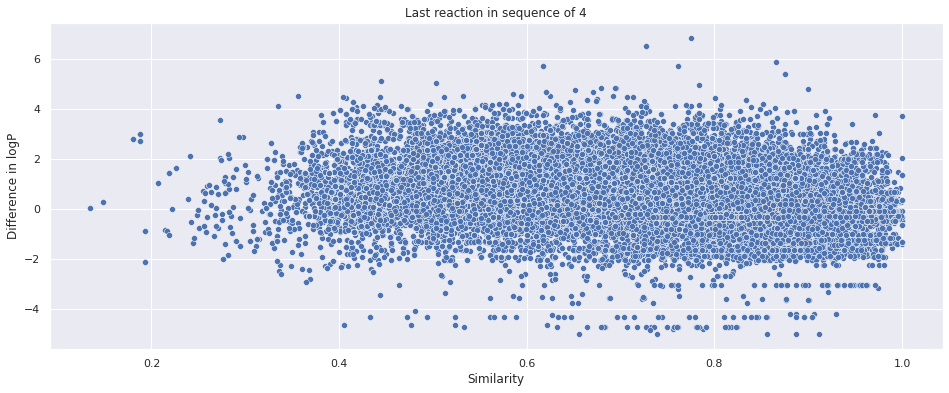

In [18]:
# Plotting against each other
i = 4
sns.scatterplot(x=sim_sequence[:, i-1], y=logp_sequence[:, i] - logp_sequence[:, i-1])
fig.set(title=f"Similarit between molecule {i} and {i+1}")
plt.title("Last reaction in sequence of 4")
plt.xlabel("Similarity")
plt.ylabel("Difference in logP")
plt.show()

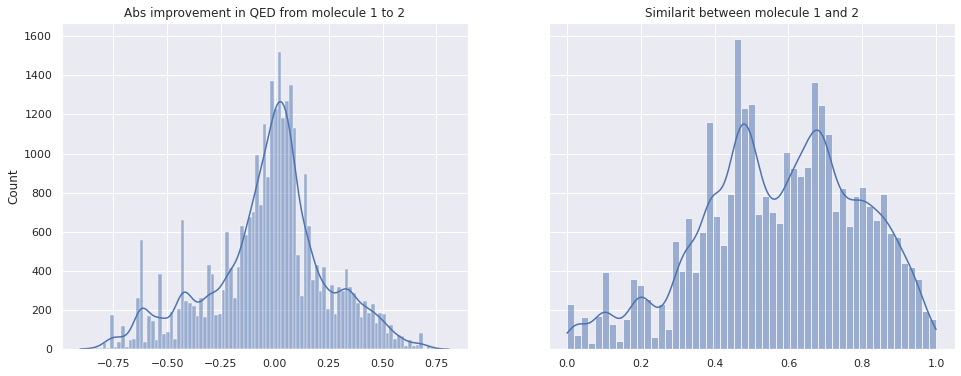

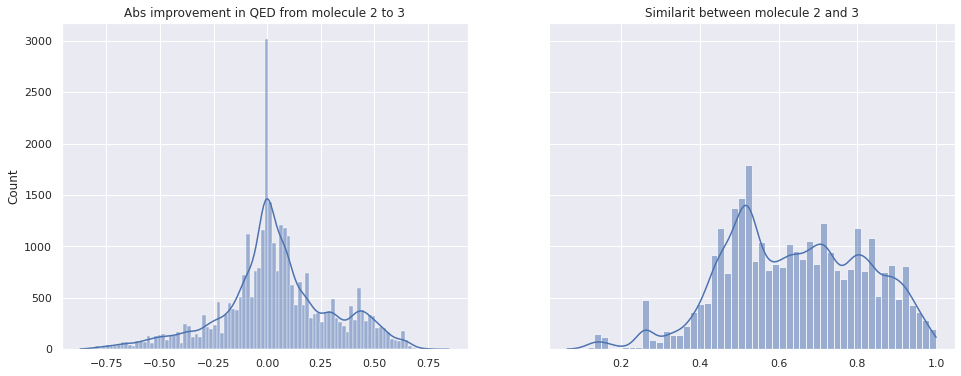

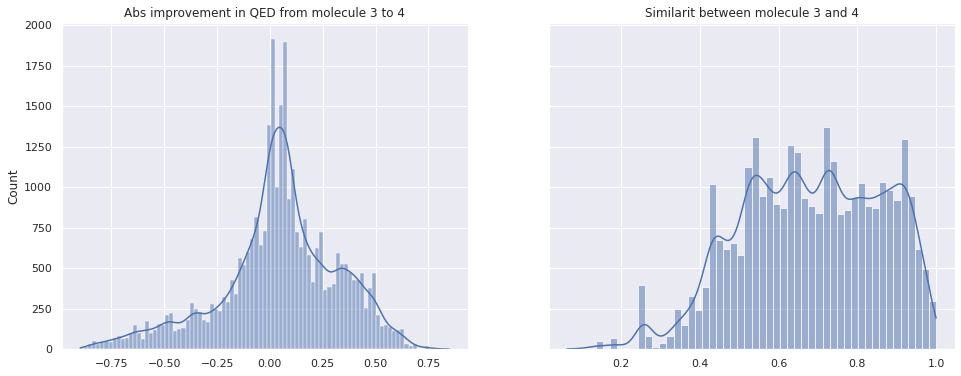

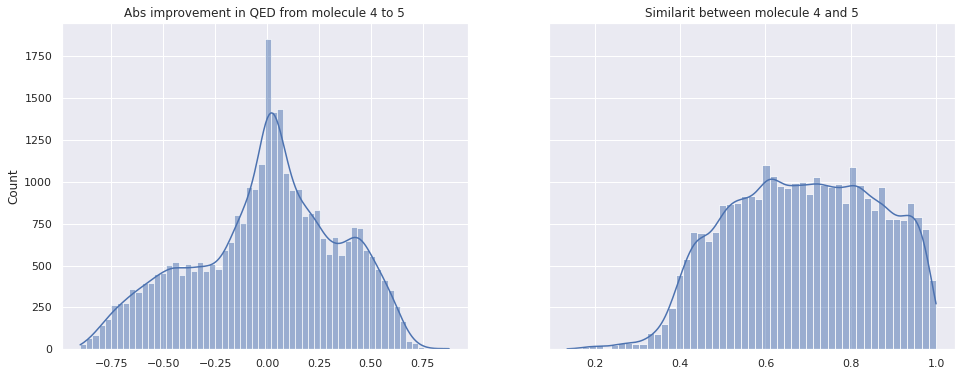

In [19]:
for i in range(1, logp_sequence.shape[1]):
    subfig, ax = plt.subplots(1, 2, sharey=True)

    fig = sns.histplot(qed_sequence[:, i] - qed_sequence[:, i-1], kde=True, ax=ax[0])
    fig.set(title=f"Abs improvement in QED from molecule {i} to {i+1}")
    
    fig = sns.histplot(sim_sequence[:, i-1], kde=True, ax=ax[1])
    fig.set(title=f"Similarit between molecule {i} and {i+1}")
    plt.show()

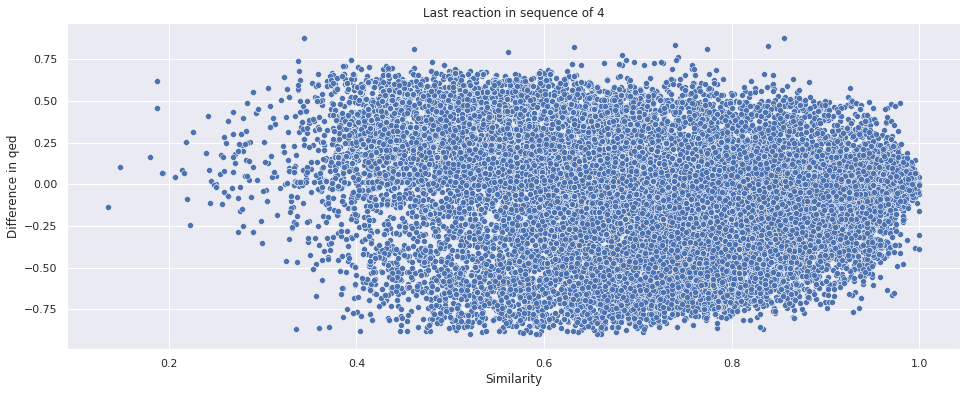

In [20]:
# Plotting against each other
i = 4
sns.scatterplot(x=sim_sequence[:, i-1], y=qed_sequence[:, i] - qed_sequence[:, i-1])
fig.set(title=f"Similarit between molecule {i} and {i+1}")
plt.title("Last reaction in sequence of 4")
plt.xlabel("Similarity")
plt.ylabel("Difference in qed")
plt.show()